``https://github.com/hhk998402/Time-Series-Forecasting-SARIMAX/blob/master/Hemant_Sangam.ipynb``

<b>Approach used:</b> SARIMAX (Seasonal Autoregressive Integrated Moving Average with eXogeneous variables)

<b> Reason:</b> The data provided is seasonal, and it is a time series data with multiple exogeneous variables influencing the result. Hence, the optimal statistical model that can be applied to this task is SARIMAX

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

Open and store the dataset as a pandas dataframe

In [26]:
# get data
df = pd.read_csv("../data/complete-merged-df.csv", index_col=0, parse_dates=True)
df.head()

,close,open,high,low,estimated-transaction-volume-usd,n-transactions,hash-rate,difficulty,cost-per-transaction,Gold price,output-volume,trade-volume,USD-CNY Price,SVI,Wikiviews
2017-01-01,998.079443,966.567909,1005.074602,961.719392,1.667890e+08,180502.0,2.463611e+06,3.176884e+11,10.914479,1377.316553,1.084341e+06,3.989748e+06,6.72991,7.000000,3139
2017-01-02,1018.369458,998.079638,1033.051602,994.997792,2.799811e+08,290951.0,2.526780e+06,3.176884e+11,7.350606,1294.600000,1.573982e+06,6.822471e+06,6.94500,18.574713,9165
2017-01-03,1036.750461,1018.367417,1037.211425,1014.576142,3.417543e+08,301664.0,2.589950e+06,3.176884e+11,7.415466,1295.600000,1.950525e+06,8.324526e+06,6.96100,18.574713,12354
2017-01-04,1137.239897,1036.750186,1146.956329,1036.327096,4.336781e+08,328642.0,2.432026e+06,3.176884e+11,7.000531,1287.300000,2.482038e+06,9.340584e+06,6.93510,18.574713,10757
2017-01-05,1002.860000,1137.239606,1165.785631,883.480930,5.657800e+08,288501.0,2.210933e+06,3.176884e+11,6.913398,1287.400000,2.998215e+06,2.387011e+07,6.89000,18.574713,11938


In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2017-01-01 to 2021-12-31
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   close                             1826 non-null   float64
 1   open                              1826 non-null   float64
 2   high                              1826 non-null   float64
 3   low                               1826 non-null   float64
 4   estimated-transaction-volume-usd  1826 non-null   float64
 5   n-transactions                    1826 non-null   float64
 6   hash-rate                         1826 non-null   float64
 7   difficulty                        1826 non-null   float64
 8   cost-per-transaction              1826 non-null   float64
 9   Gold price                        1826 non-null   float64
 10  output-volume                     1826 non-null   float64
 11  trade-volume                      1826 non-null   f

## Helper methods

In [200]:
# Accuracy metrics
import yfinance as yf
from yahoofinancials import YahooFinancials
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]   # corr
    mins = np.amin(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    return({'mape': str(round(mape*100, 3))+"%", 'me': me, 'mae': mae,
            'mpe': mpe, 'rmse': rmse,
            'corr': corr, 'minmax': minmax})


# get new data from yahoo finance
def get_new_data(ticker, start_date, end_date=date.today()):
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    return data


def plot_future(past, predicted, actual):
    plt.figure(figsize=(12, 8))
    plt.plot(predicted, label='Predicted Stock Price')
    plt.plot(actual, color='g', label='Actual Future Stock Price')
    plt.plot(past, color='r', label='Actual Stock Price')

    plt.axvline(x=max(past.index),
                color='green', linewidth=2, linestyle='--')
    plt.xticks(rotation=45, fontsize=8)
    plt.legend(shadow=True, loc='upper right')

## Prepare the data:

- Split the data into train and test samples
- Create `endog` and `exog` variables


In [28]:
# split data into train and test
top_predictors = ['close','open', 'high', 'low', 'n-transactions', 'cost-per-transaction',
                  'Gold price', 'output-volume',  'USD-CNY Price', 'SVI', 'Wikiviews']
df = df[top_predictors]

train, test = train_test_split(df, test_size=0.2, shuffle=False)
# len(train), len(test)

# Variables
exog_data = train.drop(['close'], axis=1)

exog = sm.add_constant(exog_data)
endog = train[['close']]

# # try shifting by 1 to see if it helps
# # NOTE: this is not working
# endog = train[['close']].shift(-1) 
# endog.fillna(endog.iloc[-2].values[0], inplace=True)


## Find the best order for the ARIMA model

In [140]:
# Initial approximation of parameters
Qs = range(0, 3)
qs = range(0, 4)
Ps = range(0, 4)
ps = range(0, 4)
D = 1
d = 1
parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(endog, exog=exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])


In [141]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True).head())
print(best_model.summary())


       parameters           aic
134  (2, 3, 0, 2)  19166.363496
182  (3, 3, 0, 2)  19166.867938
74   (1, 2, 0, 2)  19180.614298
137  (2, 3, 1, 2)  19182.344922
185  (3, 3, 1, 2)  19192.256249
                                       SARIMAX Results                                        
Dep. Variable:                                  close   No. Observations:                 1460
Model:             SARIMAX(2, 1, 3)x(0, 1, [1, 2], 4)   Log Likelihood               -9560.182
Date:                                Fri, 15 Apr 2022   AIC                          19166.363
Time:                                        19:33:28   BIC                          19287.867
Sample:                                    01-01-2017   HQIC                         19211.697
                                         - 12-30-2020                                         
Covariance Type:                                  opg                                         
                                       coef    s

## Build Model

In [206]:
# train model

sar = SARIMAX(endog, exog=exog, order=(2, 1, 3), seasonal_order=(0, 1, [1, 2], 4))
# mod = SARIMAX(endog, exog=exog, order=(1, 1, 2), seasonal_order=(0, 1, [1], 4))
model = sar.fit(disp=False)
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  close   No. Observations:                 1460
Model:             SARIMAX(2, 1, 3)x(0, 1, [1, 2], 4)   Log Likelihood               -9560.182
Date:                                Fri, 15 Apr 2022   AIC                          19166.363
Time:                                        21:32:15   BIC                          19287.867
Sample:                                    01-01-2017   HQIC                         19211.697
                                         - 12-30-2020                                         
Covariance Type:                                  opg                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                     0        nan        nan        nan         nan         nan
open                                -0.5148   7.97e-06  -6.46e+04      0.000      -0.515      -0.515
high                                 0.8803   1.63e-05   5.39e+04      0.000       0.880       0.880
low                                  0.6020   9.24e-06   6.52e+04      0.000       0.602       0.602
estimated-transaction-volume-usd -9.649e-09   1.08e-08     -0.897      0.370   -3.07e-08    1.14e-08
n-transactions                   -3.927e-05      0.000     -0.154      0.878      -0.001       0.000
hash-rate                         3.869e-07   1.19e-06      0.324      0.746   -1.96e-06    2.73e-06
difficulty                       -6.326e-11   2.95e-11     -2.146      0.032   -1.21e-10   -5.48e-12
cost-per-transaction                -2.0994   1.26e-07  -1.67e+07      0.000      -2.099      -2.099
Gold price                          -0.0472   2.58e-07  -1.83e+05      0.000      -0.047      -0.047
output-volume                    -4.477e-06   1.28e-05     -0.349      0.727   -2.96e-05    2.07e-05
trade-volume                     -3.236e-08    1.1e-08     -2.941      0.003   -5.39e-08   -1.08e-08
USD-CNY Price                      -37.6448    1.2e-09  -3.13e+10      0.000     -37.645     -37.645
SVI                                  1.1592   1.51e-07   7.67e+06      0.000       1.159       1.159
Wikiviews                           -0.0005      0.001     -0.998      0.318      -0.002       0.000
ar.L1                               -0.8929   3.45e-07  -2.59e+06      0.000      -0.893      -0.893
ar.L2                               -0.4932    4.4e-07  -1.12e+06      0.000      -0.493      -0.493
ma.L1                                0.0675   1.08e-06   6.23e+04      0.000       0.067       0.067
ma.L2                               -0.2397   1.36e-06  -1.77e+05      0.000      -0.240      -0.240
ma.L3                               -0.3197   1.77e-06  -1.81e+05      0.000      -0.320      -0.320
ma.S.L4                             -0.7528   2.33e-07  -3.23e+06      0.000      -0.753      -0.753
ma.S.L8                             -0.1926   2.71e-06  -7.11e+04      0.000      -0.193      -0.193
sigma2                            4.554e+04   3.68e-11   1.24e+15      0.000    4.55e+04    4.55e+04
===================================================================================
Ljung-Box (L1) (Q):                  15.34   Jarque-Bera (JB):             11156.98
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.54
===================================================

In [175]:
# adfuller test
print("Dickey–Fuller test:: p=%f" % sm.tsa.adfuller(model.resid[13:])[1])


Dickey–Fuller test:: p=0.000000


Display the residuals from the model fit in acf and pacf plots

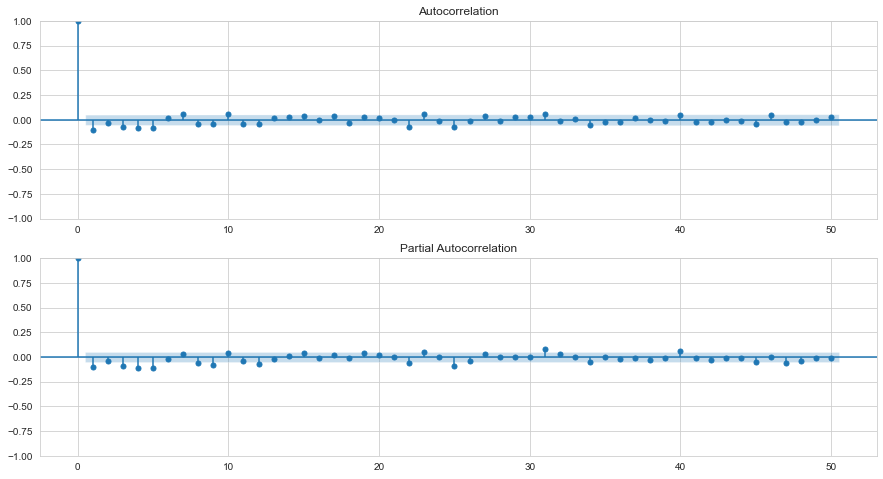

In [176]:
res = model.resid
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [207]:
pd.DataFrame(model.resid, columns=['resid']).sort_values(by='resid', ascending=False).head(5)


,resid
2017-12-22,1150.321211
2017-12-08,1008.528725
2020-12-29,983.444675
2017-12-07,874.207812
2018-01-17,850.453636


The outlier in date `2017-12-22`?

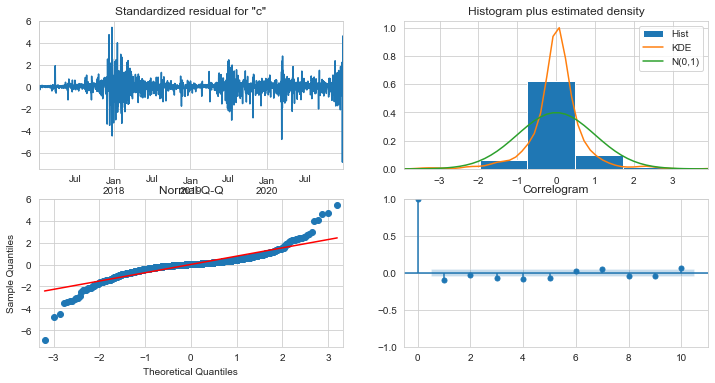

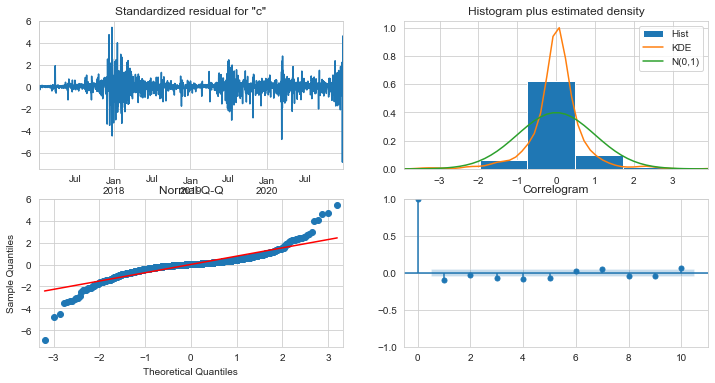

In [145]:
model.plot_diagnostics(figsize=(12, 6))

## Now lets test the model's prediction

In [208]:
# test model
first_predict, last_predict = test.iloc[0].name, test.iloc[-1].name

exog1 = (sm.add_constant(test).loc[first_predict:])
exog1 = exog1.drop(['close'], axis=1)

forecast = model.forecast(steps=len(test), exog=exog1)
result_data = pd.DataFrame(index=test.index, columns=['actual', 'pred'])

# display the forecast accuracy metrics for the test set
print(forecast_accuracy(forecast, test['close'].values))

chk = 0
for i in forecast:
    result_data.iloc[chk]["actual"] = df.iloc[df.index == test.iloc[chk].name]['close'].values[0]
    result_data.iloc[chk]["pred"] = i
    chk += 1
    
result_data.head()

{'mape': '2.08%', 'me': 311.98414366853194, 'mae': 930.941987209691, 'mpe': 0.008151685050171425, 'rmse': 1141.1261736101287, 'corr': 0.993957205223861, 'minmax': 0.020319226946252877}


,actual,pred
2020-12-31,28984.983403,28253.133893
2021-01-01,29405.123461,29292.60599
2021-01-02,32216.53,32564.887979
2021-01-03,33071.5,34236.88685
2021-01-04,32042.188855,30127.484467


We can see the predicted values are quite close to the actual values

<AxesSubplot:>

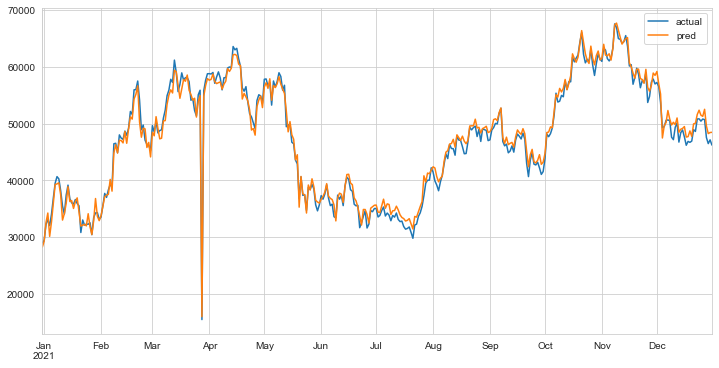

In [209]:
result_data.plot(figsize=(12, 6))

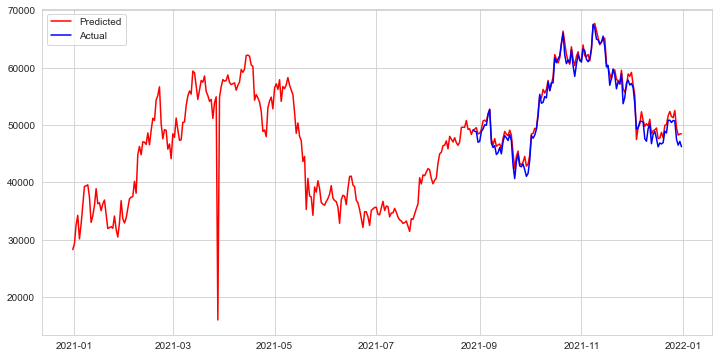

In [210]:
# plot the test data and the predicted data
plt.figure(figsize=(12, 6))

plt.plot(result_data['pred'], label='Predicted', color='red')
plt.plot(df[1700:]['close'], label='Actual', color='blue')

plt.legend(loc='upper left')


The blue label depicts the actual values, while the red label shows the prediction made. <br>
The plot shows us the model has predicted the values closely to the actual values.

### Forecast Tests
- Make a prediction using the model for the next `n-days/months/years`.
- The `get_new_data()` function gets the BPI from Yahoo Finance for the latest/given dates to compare with the predictions.
- Create a `future` DataFrame with the actual and forecasted values
- Create a mask for a short time frame and visualize it in a plot
- Calculate metrics

In [212]:
from datetime import date
from dateutil.relativedelta import relativedelta

# create a list of dates to predict
exog_last = sm.add_constant(df.drop(['close'], axis=1))[-426:]
start_index = exog_last.index.max().date()
end_index = start_index + relativedelta(days=60)

print("start_index:", start_index)
print("end_index:", end_index)

# predict using the fitted model
yhat = model.predict(start=start_index, end=end_index, exog=exog_last)

start_index: 2021-12-31
end_index: 2022-03-01


In [218]:
# get present values 
yhat_actual = get_new_data('BTC-USD', df.index[-1])

# create a new dataframe with the actual and predicted values
future = pd.DataFrame(columns=['actual',  'forecast'])
future['forecast'] = yhat
future["actual"] = yhat_actual['Close']

# NOTE: tested by deducting the MAE on the forecasted values
# future['forecast'] = future['forecast'].apply(lambda x: x - 16275)
future.head()


,actual,forecast
2021-12-31,46306.445312,61834.348261
2022-01-01,47686.812500,64319.046701
2022-01-02,47345.218750,62412.038050
2022-01-03,46458.117188,62294.518884
2022-01-04,45897.574219,62652.907571


{'mape': '37.094%',
 'me': 15018.164216469313,
 'mae': 15018.164216469313,
 'mpe': 0.37094297171057483,
 'rmse': 16275.173577228556,
 'corr': 0.21641343101473673,
 'minmax': 0.25998473328255933}

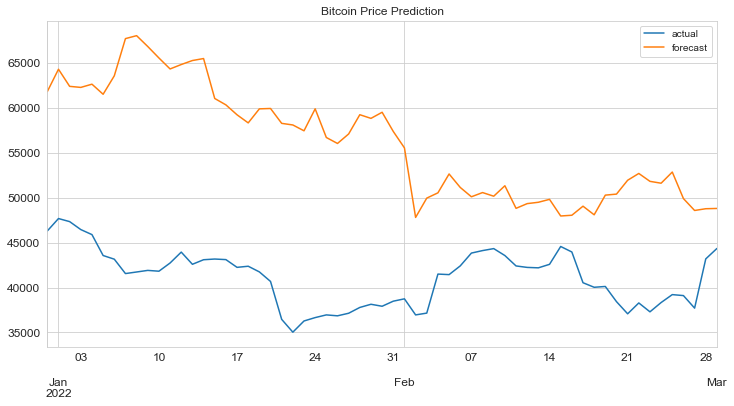

In [219]:
# compare predicted values with actual values
future.plot(figsize=(12, 6), title='Bitcoin Price Prediction', grid=True, legend=True, fontsize=12)

# The lower the MSE, the better the forecast.
forecast_accuracy(future['forecast'], future['actual'])

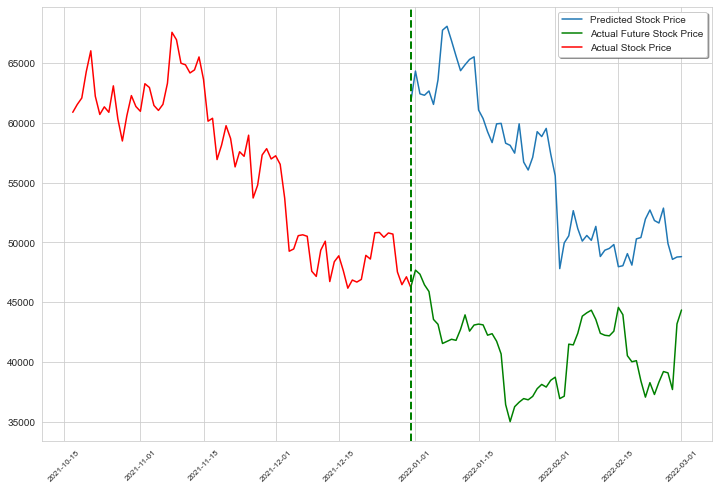

In [220]:
# comparison of the predicted values with actual values continued with historical data
plot_future(df[1750:].close, future['forecast'], future['actual'])

,Actual,Forecast,Past (y-1)
date,,,
2022-01-01,47686.812500,64319.046701,29405.123461
2022-01-02,47345.218750,62412.038050,32216.530000
2022-01-03,46458.117188,62294.518884,33071.500000
2022-01-04,45897.574219,62652.907571,32042.188855
2022-01-05,43569.003906,61531.300617,34043.030762


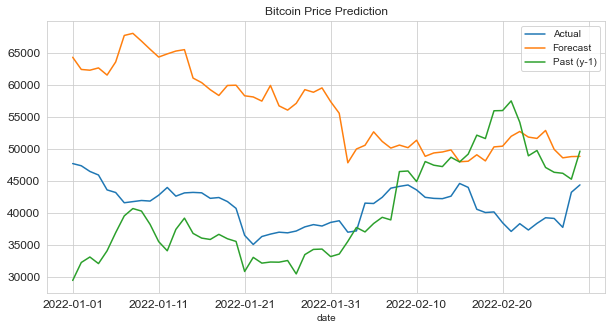

In [221]:
# create a list of data for each month in the future with the 
# date, actual value, and predicted value, and the past value on this date a year ago
cc = []
for i in range(1, 32):
    for j in range(1, 4):
        try:
            d = f'2022-0{j}-{i < 10 and f"0{i}" or i}'
            cc.append({
                    'date': d, 
                    'Forecast': future.iloc[future.index == d]['forecast'].values[0],
                    'Actual': yhat_actual.iloc[yhat_actual.index == d]['Close'].values[0],
                    'Past (y-1)': df.iloc[df.index == f'2021-0{j}-{i < 10 and f"0{i}" or i}']['close'].values[0]
            })
        except IndexError as e:
            continue

# merge the list of dictionaries into a dataframe
y_april = pd.DataFrame(cc, columns=['date','Actual', 'Forecast','Past (y-1)'])
y_april.set_index('date', inplace=True)
y_april.sort_index(inplace=True)
y_april.plot(figsize=(10, 5), title='Bitcoin Price Prediction', grid=True, legend=True, fontsize=12)
y_april.head()

The results indicate that the model is still a little rough and not something we should use as trading advice, but that was not unexpected due to the extremely volatile nature of cryptocurrencies, especially in the last 6 months.

It is probably also not such a good idea to try and predict 6 months into the future as we can see how insane even the 80% confidence interval becomes out this far. Maybe sticking to 1 month advance predictitons is more sensible. Or maybe even predicting on a daily basis.